<a href="https://colab.research.google.com/github/JARGenialutil/App_acuacultura_proyecto/blob/master/GANs_%2B_Diff_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size=10> GANs con Diff Augmentation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from cv2 import imread
from google.colab.patches import cv2_imshow

Mounted at /content/drive


<font size=7 color='steelblue'><center> Esta persona no existe:

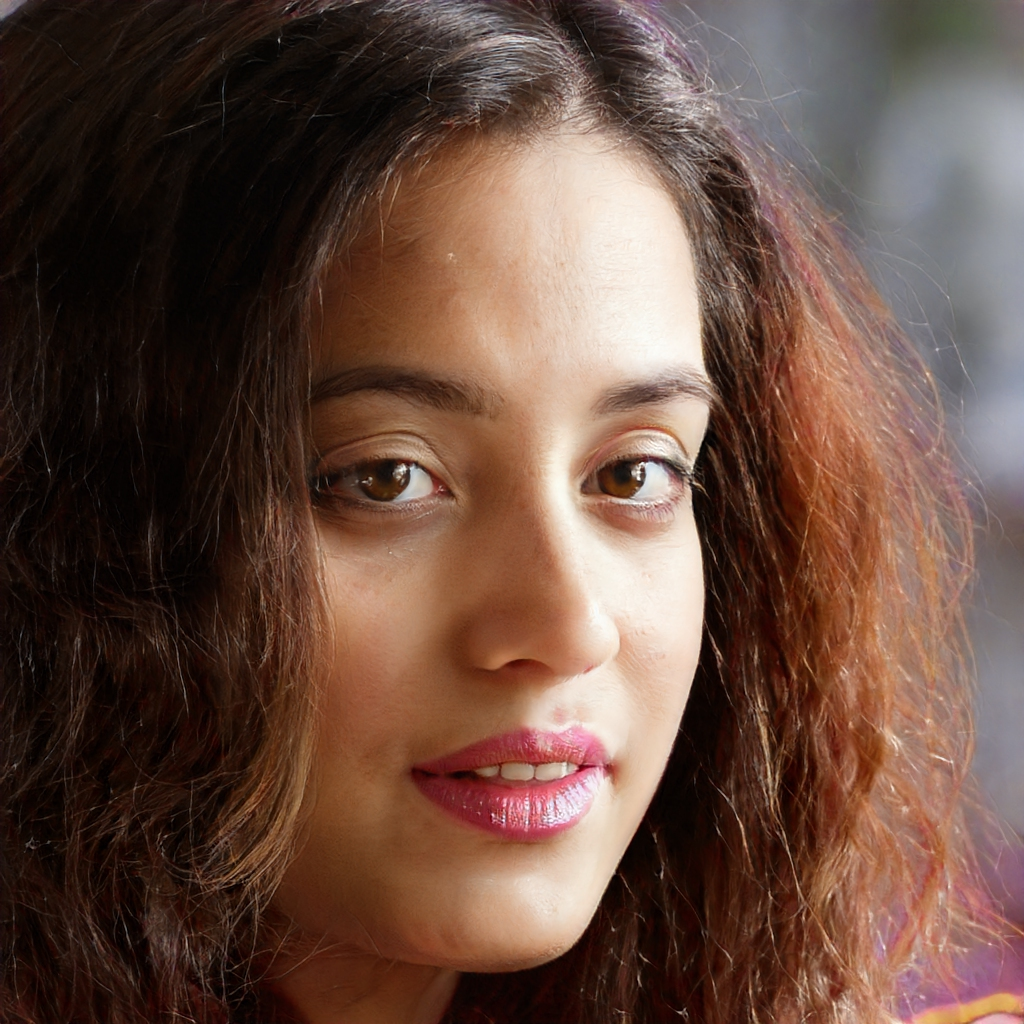

In [ ]:
img = imread('/content/drive/MyDrive/fake_person.jpg')
cv2_imshow(img)

[Enlace](https://thispersondoesnotexist.com/)

# Arquitectura de las GANS

<font size=3 color='black'>
GANs fue creado originalmente por Ian Fellow en 2014.

[Conditional Generative Adversarial Nets](./literature/Conditional-Generative-Adversarial-Nets_2014.pdf)
    
Una GAN se compone de dos redes neuronales: una red generadora y una red discriminadora. $$$$En el presente caso, Discriminator es solo una CNN, que hará una clasificación binaria entre imágenes reales y falsas. $$$$La nueva cosa interesante a cubrir es la Red Generadora, que en el presente caso también es una CNN. $$$$Esta red acepta una entrada aleatoria y, a partir de esa entrada, genera nuevos datos. El objetivo del generador es crear datos que sean realistas o percibidos como reales por el Discriminador. $$$$La entrada suele ser un vector de ruido, como verá más adelante durante este cuaderno.

# CNN: Redes convolucionales

<font size=4 color='blue'>
Convolutional neural network (CNN, or ConvNet) es una clase de red neuronal artificial (ANN), que se aplica más comúnmente para analizar imágenes visuales.

In [ ]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.animation
import matplotlib.pyplot as plt

import numpy as np
import os
from IPython.display import HTML
tf.random.set_seed(1)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

Num GPUs Available:  1


## Hiperparámetros

In [ ]:
batch_size = 128
num_epochs = 20
image_size = 64
num_channels = 1
z_size = 100
num_g_filters = 64
num_d_filters = 64
lr = 0.0002
beta1 = 0.5

## Datos

In [ ]:
(dataset, _), (_, _) = tf.keras.datasets.mnist.load_data()
dataset.shape

(60000, 28, 28)

In [ ]:
total_batches=dataset.shape[0]//batch_size
total_batches

468

In [ ]:
dataset = tf.convert_to_tensor(dataset)
dataset = tf.expand_dims(dataset, 3)
print(f'After expand_dims: {dataset.shape}')

dataset = tf.image.resize(dataset, (image_size, image_size))
print(f'After resize: {dataset.shape}')

dataset = (dataset - 127.5) / 127.5
dataset = tf.data.Dataset.from_tensor_slices(dataset) \
    .shuffle(len(dataset)).batch(batch_size)

After expand_dims: (60000, 28, 28, 1)
After resize: (60000, 64, 64, 1)


In [ ]:
def make_image_grid(images, channels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        if channels == 1:
            ax.imshow(img[:, :, 0], cmap='gray')
        else:
            ax.imshow(((img*127.5)+127.5).astype(np.uint8))
        ax.axis('off')
    return plt

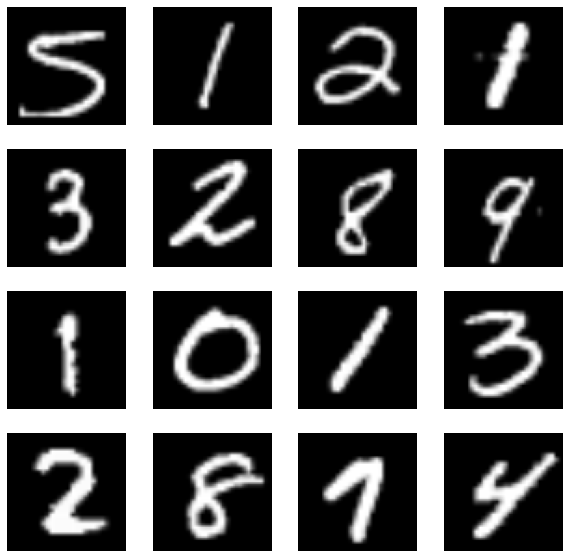

In [ ]:
real_batch = next(iter(dataset))
make_image_grid(real_batch, num_channels, 4, 4).show()

## Discriminador

![](https://byam.github.io/assets/img/gan/dcgan-discriminator.png)

In [ ]:
conv_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
netD = tf.keras.models.Sequential([
    layers.Conv2D(
        input_shape=(image_size, image_size, num_channels),
        filters=num_d_filters,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(
        filters=num_d_filters * 2,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(
        filters=num_d_filters * 4,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(
        filters=num_d_filters * 8,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(
        filters=1,
        kernel_size=4,
        strides=1,
        padding='valid',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.Activation(tf.keras.activations.sigmoid)
])

In [ ]:
netD.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_21 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 256)         524288    
                                                      

## Generador

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-01_at_11.27.51_PM_IoGbo1i.png)


In [ ]:
netG = tf.keras.models.Sequential([
    layers.Conv2DTranspose(
        input_shape=(1, 1, z_size),
        filters=num_g_filters * 8,
        kernel_size=4,
        strides=1,
        padding='valid',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2DTranspose(
        filters=num_g_filters * 4,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2DTranspose(
        filters=num_g_filters * 2,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2DTranspose(
        filters=num_g_filters,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2DTranspose(
        filters=num_channels,
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        kernel_initializer=conv_initializer
    ),
    layers.Activation(tf.keras.activations.tanh)
])

In [ ]:
netG.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_15 (Conv2D  (None, 4, 4, 512)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 256)        2097152   
 Transpose)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                     

## Entrenamiento

### Funciones auxiliares

In [ ]:
from IPython.display import display, clear_output
import pandas as pd
import time
import json
from collections import OrderedDict
from tqdm.auto import tqdm

class TrainingStatsManager():
    def __init__(self, batches_per_epoch=0):
        self.run_start_time = None
        self.epoch_start_time = None
        self.epoch_count = 0
        self.epoch_data = None
        self.epoch_results = None
        self.run_results = []
        self.progress = None
        self.batches_per_epoch = batches_per_epoch

    def begin_run(self):
        self.run_start_time = time.time()

    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_data = OrderedDict()
        self.epoch_results = OrderedDict()

        self.clear_displayed_results()
        self.display_progress()
        self.display_run_results()

    def track(self, key, value):
        if key not in self.epoch_data:
            self.epoch_data[key] = [value]
        else:
            self.epoch_data[key].append(value)

    def add_result(self, key, value):
        self.epoch_results[key] = value

    def end_epoch(self):
        results = OrderedDict()
        results['epoch'] = self.epoch_count
        results['epoch duration'] = time.time() - self.epoch_start_time
        results['run duration'] = time.time() - self.run_start_time

        for k, v in self.epoch_results.items(): results[k] = v

        self.run_results.append(results)
        self.progress.close()

    def end_run(self):
        self.clear_displayed_results()
        self.display_run_results()

    def display_progress(self):
        self.progress = tqdm(
            total=self.batches_per_epoch
            , desc=f'Epoch ({self.epoch_count}) Progress'
        )

    def display_run_results(self):
        if len(self.run_results) > 0:
            display(pd.DataFrame.from_dict(self.run_results, orient='columns'))

    def clear_displayed_results(self):
        clear_output(wait=True)

    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data
            ,orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

### Funciones de pérdida (Loss functions)

In [ ]:
# Función de pérdida del discriminador
bce_loss = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [ ]:
# Función de pérdida del generador
def generator_loss(fake_output):
    return bce_loss(tf.ones_like(fake_output), fake_output)

In [ ]:
g_losses = []
d_losses = []

### Optimizadores

In [ ]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)

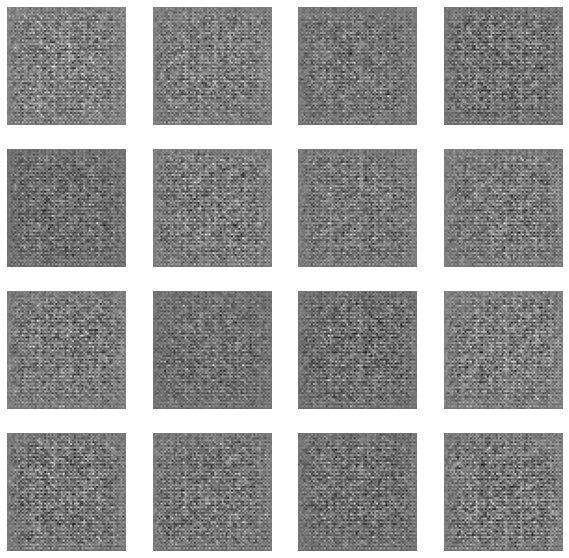

In [ ]:
# Create batch of random noise vectors to later visualize progression of the generator
fixed_noise = tf.random.normal(shape=(64, 1, 1, z_size))

fixed_fakes = netG(fixed_noise, training=False)
make_image_grid(fixed_fakes, num_channels, 4, 4).show()

### Ciclo de entrenamiento

epoch  epoch duration  run duration    D loss    G loss  avg D(x)  \
0       1       97.801496     97.801940  0.626678  3.307342  0.825895   
1       2       95.956743    193.759488  0.775663  2.062281  0.737602   
2       3       95.941483    289.701783  0.829858  1.818068  0.720554   
3       4       96.061942    385.764713  0.892504  1.633902  0.692771   
4       5       95.401188    481.167056  0.891214  1.615395  0.693388   
5       6       95.625571    576.793215  0.836996  1.779808  0.713907   
6       7       95.496118    672.290024  0.748756  2.044413  0.745641   
7       8      142.144764    814.435492  0.695988  2.230862  0.767026   
8       9       97.039614    911.476208  0.619942  2.436642  0.792732   
9      10      142.146378   1053.623674  0.560606  2.655901  0.816725   
10     11       96.222807   1149.847605  0.641214  2.489100  0.796281   
11     12       95.833409   1245.681710  0.474950  3.061244  0.849088   
12     13      142.140237   1387.823233  0.467024  3.142246  0.853796   
13     14       96.564802   1484.389126  0.502090  3.025315  0.842684   
14     15      142.153127   1626.542961  0.430450  3.318528  0.865221   
15     16      142.145302   1768.689379  0.470665  3.349168  0.859561   
16     17       96.206060   1864.896559  0.399186  3.594155  0.878251   
17     18      142.120785   2007.018083  0.414182  3.587383  0.875058   
18     19       95.970395   2102.989484  0.335026  3.939383  0.895045   
19     20       95.687450   2198.677633  0.378304  3.784024  0.886360   

    avg D(G(z)) pre  avg D(G(z)) post  
0          0.211621          0.119682  
1          0.265667          0.189973  
2          0.285833          0.238169  
3          0.312374          0.263881  
4          0.310957          0.272182  
5          0.292022          0.243369  
6          0.259309          0.210951  
7          0.238001          0.189351  
8          0.211013          0.166959  
9          0.187125          0.148905  
10         0.206998          0.174409  
11         0.154716          0.122430  
12         0.150025          0.120102  
13         0.160128          0.133968  
14         0.138503          0.113208  
15         0.143646          0.119431  
16         0.125185          0.102238  
17         0.128629          0.103332  
18         0.107885          0.084883  
19         0.116848          0.094542

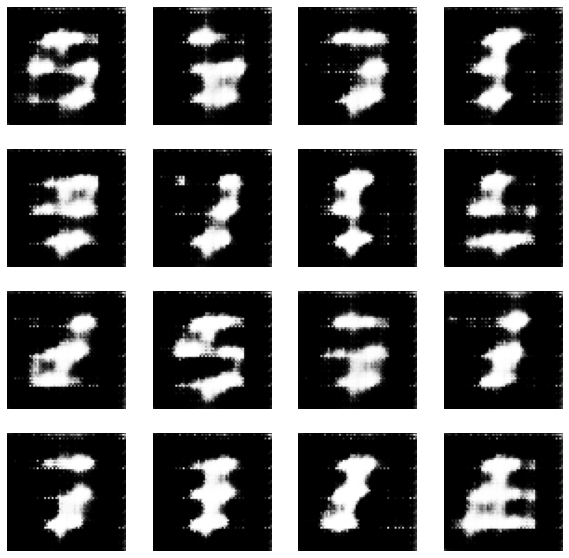

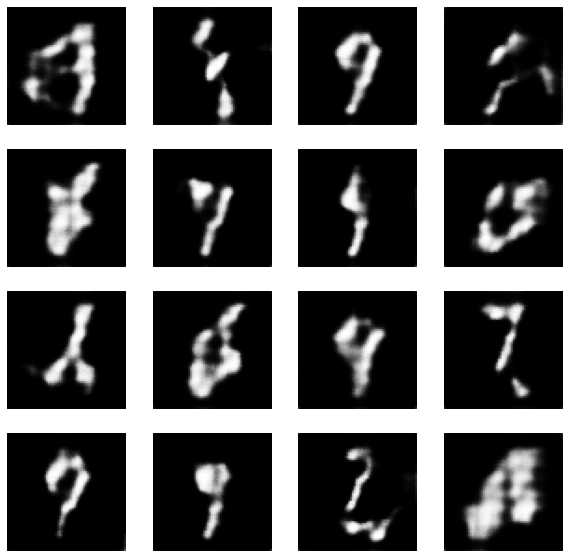

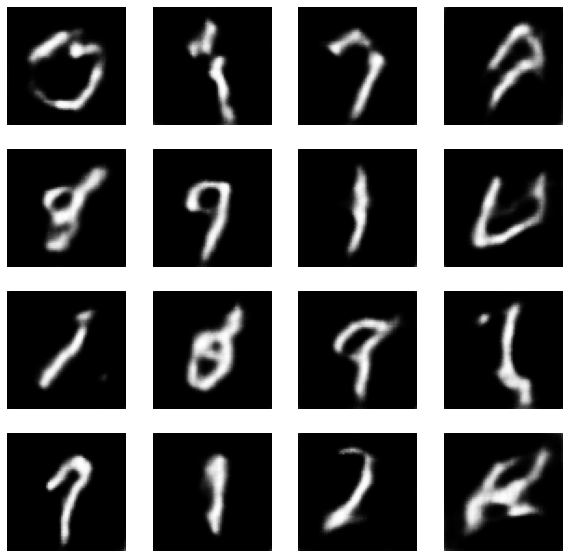

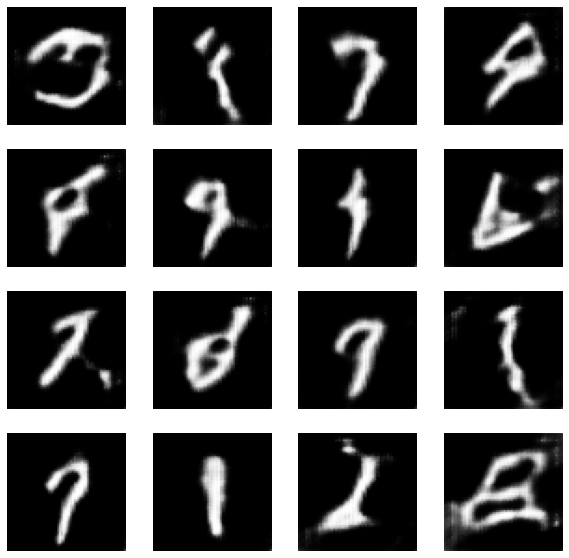

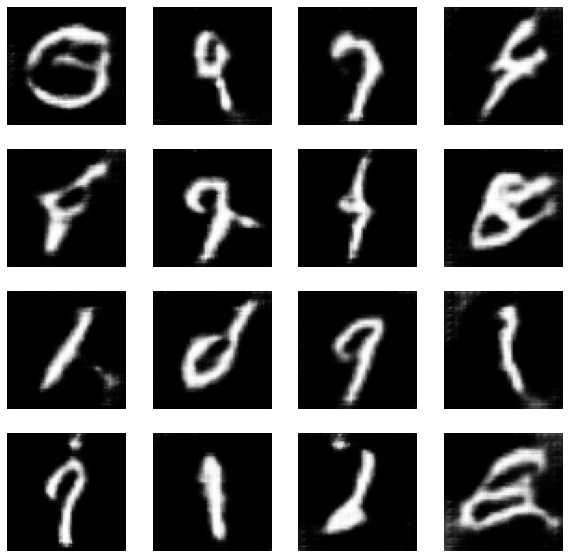

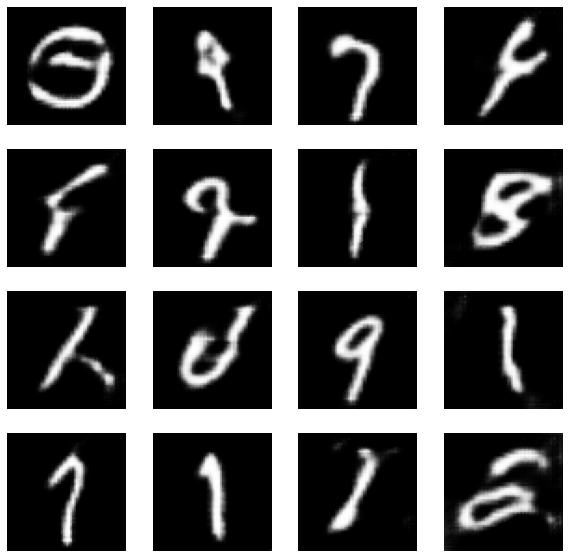

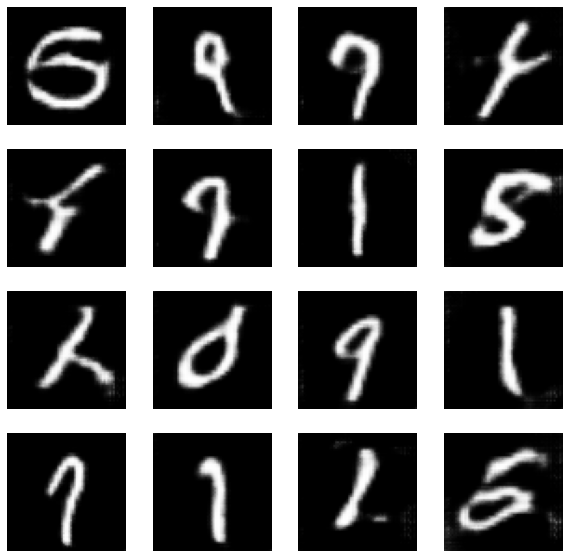

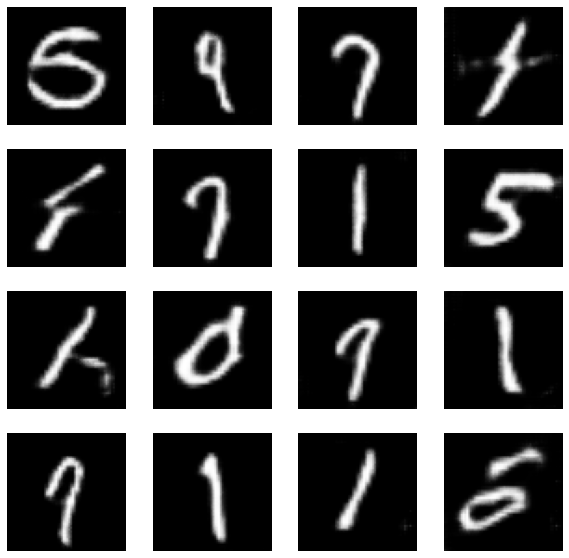

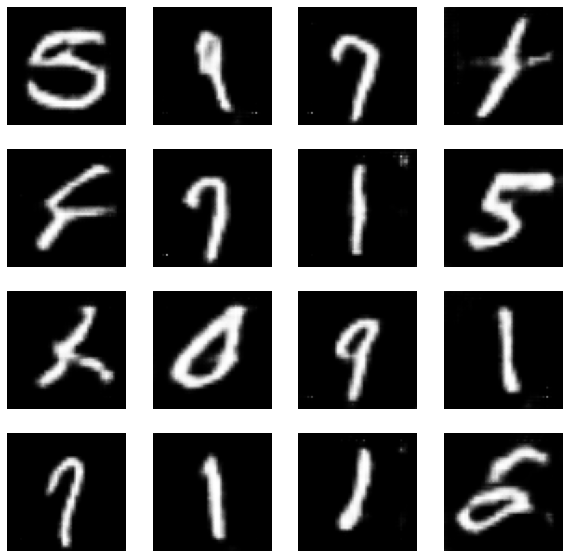

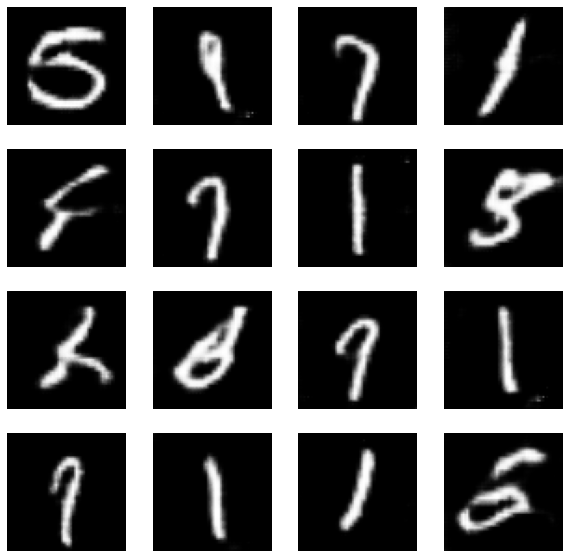

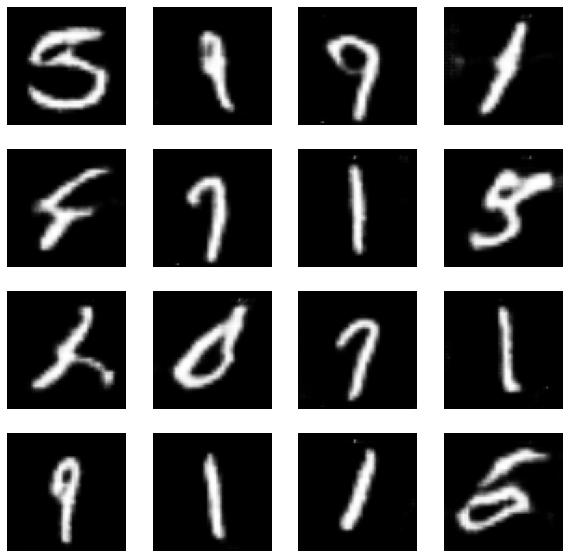

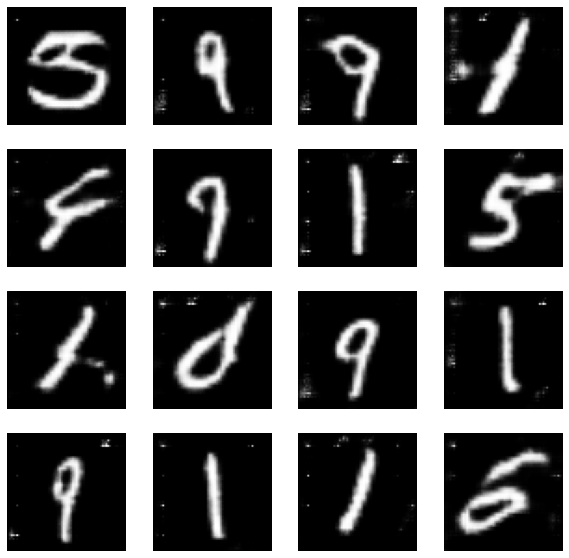

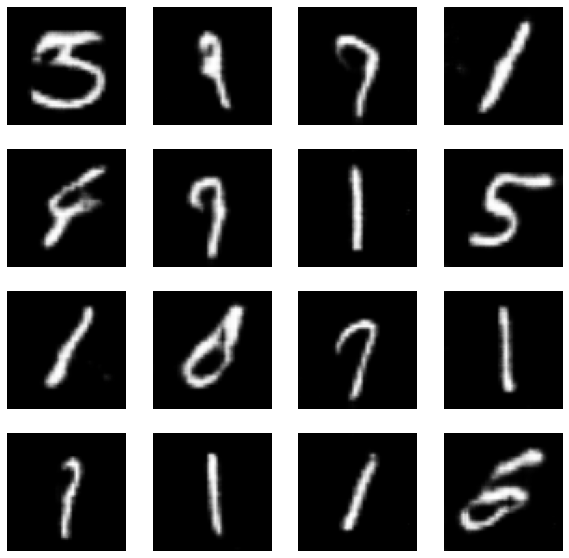

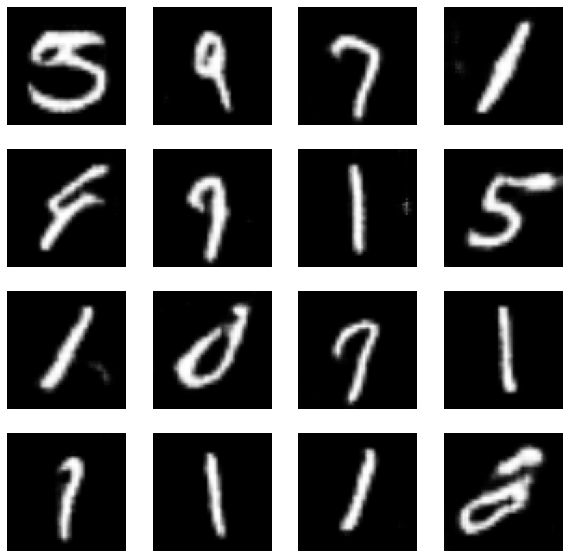

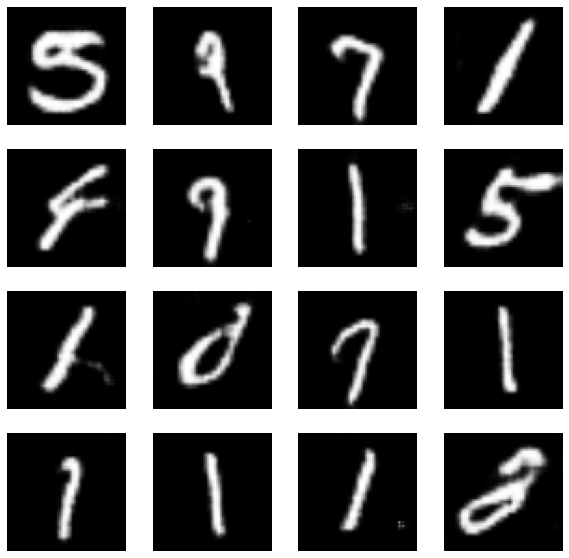

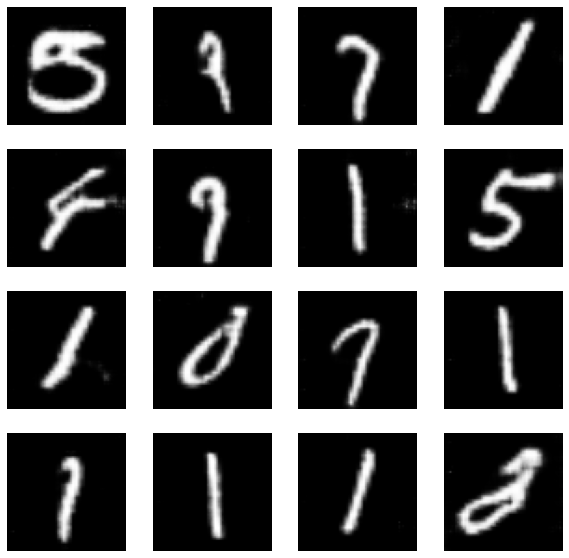

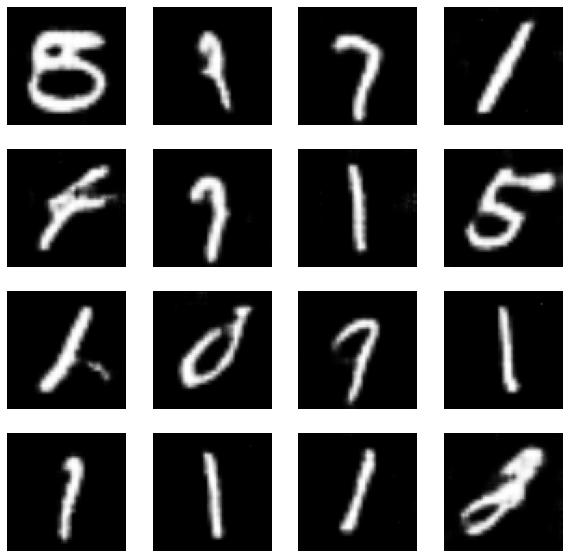

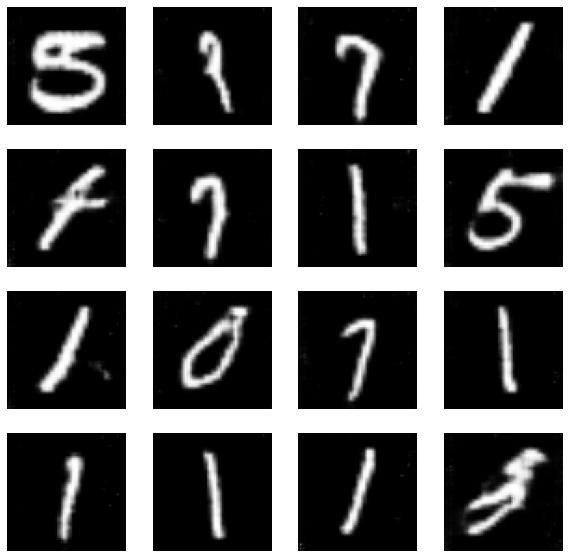

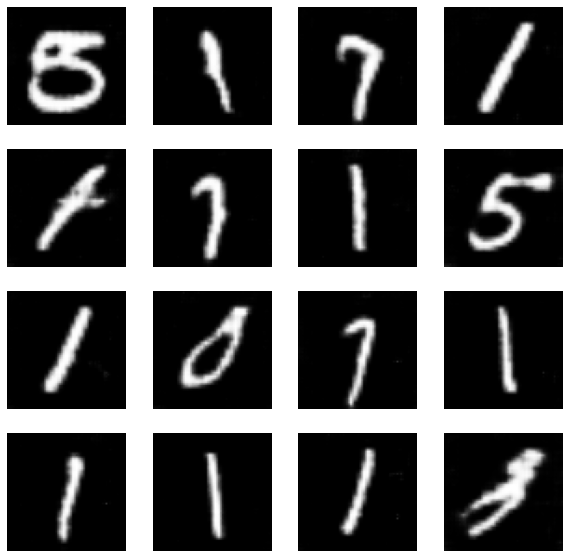

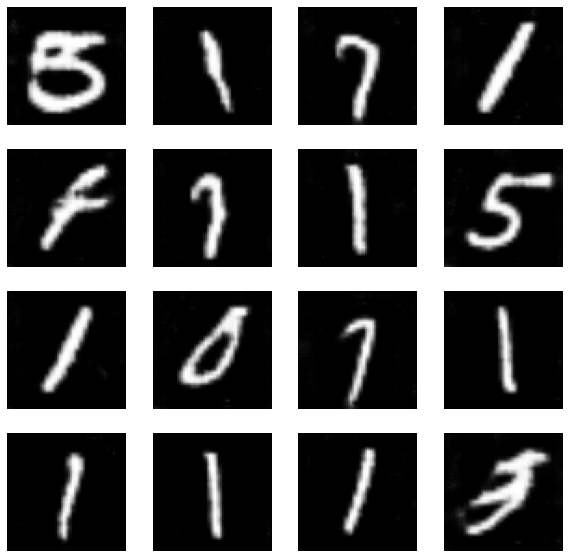

In [ ]:
stats = TrainingStatsManager(batches_per_epoch=total_batches)
stats.begin_run()

for epoch in range(num_epochs):
    stats.begin_epoch()

    for batch in dataset:
        noise = tf.random.normal(shape=(batch.shape[0], 1, 1, z_size))

        # TRAIN DISCRIMINATOR
        with tf.GradientTape() as d_tape:
            real_output = netD(batch)
            fake_images = netG(noise, training=False)
            fake_output = netD(fake_images)
            d_loss = discriminator_loss(real_output, fake_output)

        d_grads = d_tape.gradient(d_loss, netD.trainable_variables)
        d_optimizer.apply_gradients(zip(d_grads, netD.trainable_variables))

        stats.track('real_mean', tf.math.reduce_mean(real_output).numpy())
        stats.track('fake_mean1', tf.math.reduce_mean(fake_output).numpy())
        stats.track('d_loss', d_loss.numpy())

        # TRAIN GENERATOR
        with tf.GradientTape() as g_tape:
            fake_images = netG(noise)
            fake_output = netD(fake_images, training=False)
            g_loss = generator_loss(fake_output)

        g_grads = g_tape.gradient(g_loss, netG.trainable_variables)
        g_optimizer.apply_gradients(zip(g_grads, netG.trainable_variables))

        stats.track('fake_mean2', tf.math.reduce_mean(fake_output).numpy())
        stats.track('g_loss', g_loss.numpy())
        stats.progress.update()

    fixed_fakes = netG(fixed_noise, training=False)
    make_image_grid(fixed_fakes, num_channels, 4, 4)

    g_losses.append(sum(stats.epoch_data['g_loss'])/total_batches)
    d_losses.append(sum(stats.epoch_data['d_loss'])/total_batches)

    stats.add_result('D loss', sum(stats.epoch_data['d_loss'])/total_batches)
    stats.add_result('G loss', sum(stats.epoch_data['g_loss'])/total_batches)
    stats.add_result('avg D(x)', sum(stats.epoch_data['real_mean'])/total_batches)
    stats.add_result('avg D(G(z)) pre', sum(stats.epoch_data['fake_mean1'])/total_batches)
    stats.add_result('avg D(G(z)) post', sum(stats.epoch_data['fake_mean2'])/total_batches)
    stats.end_epoch()

stats.end_run()

En el archivo de arriba podemos ver como cambian conforme a cada epoca las imagenes falsas, van mejorando!




## Evaluación

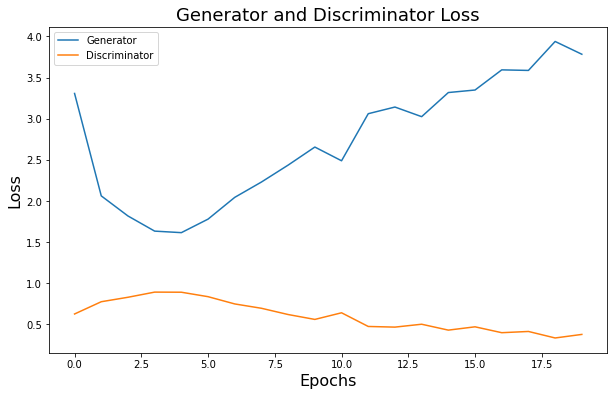

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Generator and Discriminator Loss", size=18)
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("Epochs", size=16)
plt.ylabel("Loss", size=16)
#plt.xticks(ticks=np.arange(len(g_losses)), labels=np.arange(1, len(g_losses)+1))
plt.legend()
plt.show()

# Desventajas de las GANs tradicionales



*   Dependen demasiado en cantidades masivas y de alta resolución de imágenes

*   Su entrenamiento es altamente inestable

*   Requieren de ajustes muy precisos de hiperparámetros
*   El discriminador tiende a memorizar los datos sin importar el tamaño del conjunto de entrenamiento


# Differentiable Augmentation

La mayoría de las mejoras que se han hecho están enfocadas en 'penalizar' al discriminador para que no memorice los datos, sin embargo poco se ha hecho para abordar la cuestión de la cantidad masiva de datos necesarios para entrenar.

Técnicas tradicionales de *data augmentation* no son viables ya que afectan el desempeño del generador.

Como vimos anteriormente, las funciones de pérdida para ambas redes se definen como:

$$L_D = \textbf{E}_x[f_D(-D(x))] + \textbf{E}_z[f_D(D(G(z))]$$

$$L_G = \textbf{E}_z[f_G(-D(G(z)))] $$


Si se aplicara *data augmentation* tradicional, las funciones de pérdida se expresarían:

$$\textbf{E}_x[f_D(-D(T(x))))] + \textbf{E}_z[f_D(D(G(z))] $$

$$L_G = \textbf{E}_z[f_G(-D(G(z)))] $$

Sin embargo, esto provoca que el generador aprenda estas modificaciones, lo que causa que las imágenes resultantes contengan las transformaciones utilizadas con el *data augmentation*, que reulta en un peor desempeño. El siguiente paso lógico es aplicar la misma transformación que se utilizó en la imagen original a la imagen falsa del generador, lo que resulta:

$$\textbf{E}_x[f_D(-D(T(x))))] + \textbf{E}_z[f_D(D(T(G(z)))] $$

$$L_G = \textbf{E}_z[f_G(-D(G(z)))] $$

Sin embargo, esto produce aún peores resultados, ya que el discriminador aprende a diferenciar $T(x)$ y T(G(z)), pero no $G(z)$, que es la imagen producida por el generado, por lo que no recibe retroalimentación y su desempeño empeora.

Entonces, se plantea que aquellas transformaciones hechas para el discriminador deben de ser consideradas también para el generador, de forma que resulta:

$$\textbf{E}_x[f_D(-D(T(x))))] + \textbf{E}_z[f_D(D(T(G(z)))] $$

$$L_G = \textbf{E}_z[f_G(-D(T(G(z))))] $$

Sin embargo, por el proceso de entrenamiento del generador, para que estos valores sean calculables durante el proceso de *back propagation* las transformaciones utilizadas deben de ser diferenciables, de ahí el nombre $Differentiable$ $Augmentation$


Para más información consultar el siguiente vídeo de youtube https://www.youtube.com/watch?v=yADlUOCQDy0&t=4s